In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy import distance
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from uszipcode import SearchEngine

In [2]:
data_dir = os.getcwd() + '/yelp_dataset'

def load_dataset(data_dir, file):
    df = pd.DataFrame([])
    data_chunk = pd.read_json(os.path.join(data_dir, file), lines=True, chunksize=100000)
    for chunk in data_chunk:
          df = pd.concat([df, chunk])
    return df

print('Loading business data ...')
df_business = load_dataset(data_dir, 'business.json')
print('Loading checkin data ...')
df_checkin = load_dataset(data_dir, 'checkin.json')
print('Loading review data ...')
df_review = load_dataset(data_dir, 'review.json')

print('All datasets have been loaded!')

Loading business data ...
Loading checkin data ...
Loading review data ...
All datasets have been loaded!


## Enrich features for businesses in US 

In [3]:
def enrich_business_features(df):
    """
    enrich business in the US with population, population density,
    land area and median household income by searching with zipcode
    """
    # list of US state abbreviations
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    # keep only businesses in US
    df_business_us = df[df['state'].isin(states)]
    # get rid of missing zipcode items
    df_with_zipcode = df_business_us[~(df_business_us['postal_code']=='')] 
    # activate search search engine which would provide more features relate to zipcode
    search = SearchEngine(simple_zipcode=True)
    df_zipcode = pd.DataFrame()
    zipcode = df_with_zipcode['postal_code'].unique()
    df_zipcode['postal_code'] = zipcode
    # perform searching and enrich features
    df_zipcode['population'] = [search.by_zipcode(i).to_dict()['population'] for i in tqdm(zipcode)]
    df_zipcode['population_density'] = [search.by_zipcode(i).to_dict()['population_density'] for i in tqdm(zipcode)]
    df_zipcode['land_area_in_sqmi'] = [search.by_zipcode(i).to_dict()['land_area_in_sqmi'] for i in tqdm(zipcode)]
    df_zipcode['median_household_income'] = [search.by_zipcode(i).to_dict()['median_household_income'] for i in tqdm(zipcode)]
    # merge features to business dataframe
    df = df_business_us.merge(df_zipcode, how='left', on='postal_code').dropna()
    
    return df

df_business = enrich_business_features(df_business)

100%|██████████| 891/891 [00:00<00:00, 1300.24it/s]


## Extract review features and merge into business

In [4]:
def review_features(df):
    print('Extracting review features ...')
    # get total number of 'cool', 'funny' and 'useful'
    df_review_statistic = df.groupby('business_id')[['cool', 'funny', 'useful']].sum()
    # get average stars
    df_review_statistic['avg_stars_review'] = df.groupby('business_id')[['stars']].mean()
    # group review timestamps into a list
    df_review_statistic['date'] = df.groupby('business_id')['date'].apply(list)
    review_date = df_review_statistic['date'].values
    # get number of reviews
    df_review_statistic['review_count'] = [len(dates) for dates in review_date]
    # extract 1st and last review year and month
    review_start = [min(i) for i in review_date]
    review_latest = [max(i) for i in review_date]
    df_review_statistic['review_start_year'] = list(map(lambda x: x.year, review_start))
    df_review_statistic['review_start_month'] = list(map(lambda x: x.month, review_start))
    df_review_statistic['review_latest_year'] = list(map(lambda x: x.year, review_latest))
    df_review_statistic['review_latest_month'] = list(map(lambda x: x.month, review_latest))
    # get duration of review in years
    review_duration = np.array(review_latest) - np.array(review_start)
    print('Calculating business duration accoring to review time...')
    df_review_statistic['review_duration'] = [item/pd.Timedelta(days=365.25) for item in tqdm(review_duration)]
    # get review rate per month
    df_review_statistic['review_per_month'] = df_review_statistic['review_count']/df_review_statistic['review_duration']/12
    # drop redundant columns
    df_review_statistic.drop(columns=['date', 'review_count'], inplace=True)
    print('Review features extracted!')
    
    return df_review_statistic

df_review_statistic = review_features(df_review)
df_business = df_business.merge(df_review_statistic, on='business_id', how='inner')

Extracting review features ...


  4%|▎         | 6758/192606 [00:00<00:02, 67571.20it/s]

Calculating business duration accoring to review time...


100%|██████████| 192606/192606 [00:02<00:00, 71360.99it/s]


Review features extracted!


## Extract checkin featueas and merge into business

In [5]:
def checkin_features(df):
    print('Extracting checkin features...')
    checkin = df['date'].values
    checkin_split = list(map(lambda x: x.split(','), checkin))
    # extract 1st and last checkin time
    checkin_start = np.array([pd.Timestamp(i[0]) for i in checkin_split])
    checkin_stop = np.array([pd.Timestamp(i[-1]) for i in checkin_split])
    # get duration of checkin 
    checkin_duration = checkin_stop - checkin_start
    df['checkin_duration'] = [item/pd.Timedelta(days=365.25) for item in checkin_duration]
    # extract 1st and last checkin year and month
    df['checkin_start_year'] = list(map(lambda x: x.year, checkin_start))
    df['checkin_start_month'] = list(map(lambda x: x.month, checkin_start))
    df['checkin_latest_year'] = list(map(lambda x: x.year, checkin_stop))
    df['checkin_latest_month'] = list(map(lambda x: x.month, checkin_stop))
    # get number of checkins
    df['checkin_count'] = list(map(lambda x: len(x), checkin_split))
    # calculate checkins per month
    df['checkin_per_month'] = df['checkin_count']/df['checkin_duration']/12
    df.drop(columns=['date'], inplace=True)
    print('Checkin features have been extracted!')
    
    return df

df_checkin = checkin_features(df_checkin)
df_business = df_business.merge(df_checkin, on='business_id', how='inner')

Extracting checkin features...
Checkin features have been extracted!


## Cluster business with Geo-coordinates

In [9]:
def business_clustering(df):
    print("Clustering business according to Geo-coordinates ...")
    """
    DBSCAN - Density-Based Spatial Clustering of Applications with Noise
    """
    coords = df[['latitude', 'longitude']].values
    # radius of the earth in km
    kms_per_radian = 6371
    # the minimus distance between two restruants is 50m
    epsilon = .05 / kms_per_radian
    # perform clustering
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    df['coords_cluster_label'] = cluster_labels
    # number of business in each cluster
    counts_cluster = [len(cluster) for cluster in clusters]
    df['neighbors'] = [counts_cluster[i] for i in cluster_labels]
    # if the number of neighbors > 20, the business in a chain
    df['is_chain'] = df['neighbors'] >=5
    df['is_chain'] = df_business['is_chain'].astype(int)
    
    return df

df_business = business_clustering(df_business)
df_business.to_pickle(os.path.join(data_dir, 'features.pkl'))

Clustering business according to Geo-coordinates ...
Number of clusters: 38063


In [9]:
df_business.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count_x', 'stars', 'state', 'population', 'population_density',
       'land_area_in_sqmi', 'median_household_income', 'cool', 'funny',
       'useful', 'stars_review', 'review_count_y', 'review_start_year',
       'review_start_month', 'review_latest_year', 'review_latest_month',
       'review_duration', 'review_per_month', 'checkin_duration',
       'checkin_start_year', 'checkin_start_month', 'checkin_latest_year',
       'checkin_latest_month', 'checkin_count', 'checkin_per_month',
       'coords_cluster_label', 'neighbors', 'is_chain'],
      dtype='object')

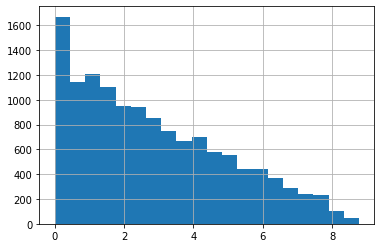

In [13]:
df_business[df_business['is_open']==0]['checkin_duration'].hist(bins=20)
plt.show()

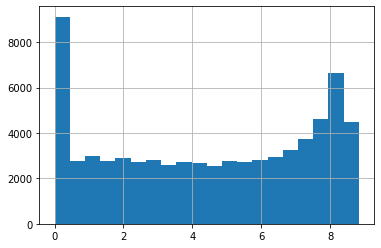

In [14]:
df_business[df_business['is_open']==1]['checkin_duration'].hist(bins=20)
plt.show()

In [17]:
df_business.iloc[0]

address                                            10110 Johnston Rd, Ste 15
attributes                 {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...
business_id                                           gnKjwL_1w79qoiV3IC_xQQ
categories                                 Sushi Bars, Restaurants, Japanese
city                                                               Charlotte
hours                      {'Monday': '17:30-21:30', 'Wednesday': '17:30-...
is_open                                                                    1
latitude                                                             35.0926
longitude                                                           -80.8591
name                                             Musashi Japanese Restaurant
postal_code                                                            28210
review_count_x                                                           170
stars                                                                      4

In [ ]:
# text idea to group business
# https://www.kaggle.com/ksjpswaroop/yelp-data-analysis